# 1. Download data from Kaggle



In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

uploaded = files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/*
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

Saving kaggle.json to kaggle.json
/root/.kaggle/kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-03 22:53:52          42822  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        246KB  2020-04-05 15:21:07           1162  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            348  
vitaliymalcev/russian-passenger-air-service-20072020           Russian passenger air service 2007-2020             239KB  2020-04-02 22:27:03    

# 2. Data Preprocessing & Exploratory Data Analysis

keras version: 2.3.0-tf


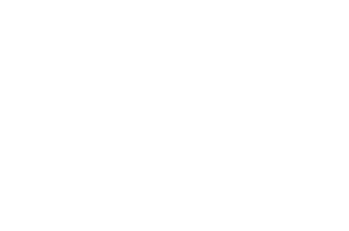

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
print(f"keras version: {keras.__version__}")
# print(f"pandas version: {pd.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
original_train_df = pd.read_csv("training.zip")
original_test_df = pd.read_csv("test.zip")

In [0]:
# helper function to plot 9 pictures and their respective point of interest, 
# this is called later to show examples of training data and predicted outputs
def plot_images(img_array, poi_actual, poi_extrapolated, for_missing_data = True):
  fig, ax = plt.subplots(3,3, figsize=(15,15))
  plt.setp(ax, xticks=(), yticks=())  
  for row in range(9):   
      image = img_array[row,:].reshape(96, 96)
      curr_poi_actual = poi_actual[row,:]
      curr_poi_extrapolated = poi_extrapolated[row,:]
      i = int(np.floor(row/3))
      j = int(np.mod(row,3))

      ax[i,j].imshow(image, cmap="gray")

      poi_actual_zipped = list(zip(curr_poi_actual[::2], curr_poi_actual[1::2]))
      poi_extrapolated_zipped = list(zip(curr_poi_extrapolated[::2], curr_poi_extrapolated[1::2]))

      if for_missing_data:
        poi_extrapolated_zipped = list(set(poi_extrapolated_zipped) - set(poi_actual_zipped))
      
      for p in poi_actual_zipped:
          ax[i,j].scatter(p[0], p[1], s=80, c='#33a02c', marker='P')

      for p in poi_extrapolated_zipped:
          if for_missing_data:
              ax[i,j].scatter(p[0], p[1], s=60, c='#fb9a99', marker='o')
          else:
              ax[i,j].scatter(p[0], p[1], s=60, c='#fb9a99', marker='o', alpha = 0.6)

  plt.show()

# helper function to plot the validation result from the model
def plot_history(history, name, RMSE_TF=False):
  plt.figure(figsize=(12,8))

  plt.plot(history['loss'], linewidth=3,color = "red", alpha = 0.8, label='loss')
  plt.plot(history['mae'], linewidth=3,color = "blue", alpha = 0.8, label='mae')

  if 'val_loss' in history:
    plt.plot(history['val_loss'], "--", linewidth=3, color = "red", alpha = 0.8, label='val_loss')
    plt.plot(history['val_mae'], "--", linewidth=3, color = "blue", alpha = 0.8, label='val_mae')
  
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log value")
  plt.title(name)
  plt.legend()
  plt.grid(True)
  plt.show()

In [4]:
# EDA on missing data
print(original_train_df.info())

# find out number of number of rows with missing values
print(f"Total number of rows: {original_train_df.shape[0]}")
print(f"Total number of rows with NaN : {original_train_df.shape[0] - original_train_df.dropna().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

<Figure size 1440x1440 with 0 Axes>

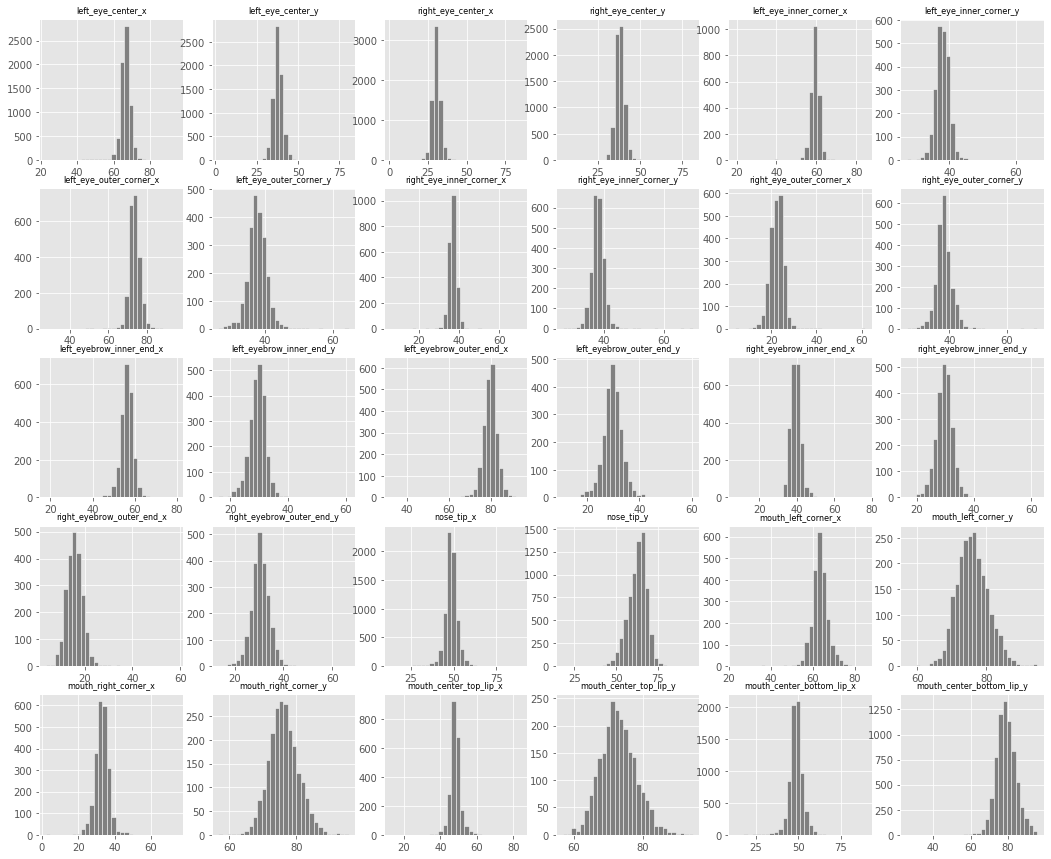

In [5]:
# histogram analysis of the training data's point of interest coordinates

plt.figure( figsize = (20, 20))

fig, ax = plt.subplots(5,6, figsize=(18,15)) 
for c in range(30):  
    curr_column = original_train_df.columns[c] 
    i = int(np.floor(c/6))
    j = int(np.mod(c,6))

    original_train_df[curr_column].hist(bins = 30, color = "gray", edgecolor = "white", ax=ax[i, j])
    ax[i, j].set_title(curr_column, fontdict = {'fontsize': 8})

plt.show()

There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. There are `4909` rows with missing values. 

It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are `left_eye_center_x `, `left_eye_center_y`, `right_eye_center_x`, `right_eye_center_y`, `mouth_center_bottom_lip_x`, and `mouth_center_bottom_lip_y`. Second group of features have the number of rows between 2225 ~ 2275. How do we handle this? Should we create two different models to handle each group? Or move the rows with missing values? Or fill in missing values other values. 

In [6]:
# create inputs for train, dev, test. Each row is pixel grayscale value for one image.

# get the image data from training csv, convert into ndarray, reshape into the shape the CNN requires)
train_input = [x.split(' ') for x in original_train_df['Image'].tolist()]
train_input = np.asarray(train_input).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)

# divide input data up into train and dev set
X_train = train_input[:6000]
X_dev = train_input[6000:]

print('training set input shape:', X_train.shape)
print('development set input shape:', X_dev.shape)

# get the image data from test csv, convert into ndarray
X_test = [x.split(' ') for x in original_test_df['Image'].tolist()]
X_test = np.asarray(X_test).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)

print('test set input shape:', X_test.shape)

# get the real data as an ndarray before filling
Y_real= original_train_df.drop('Image', axis = 1).to_numpy()

# divide output data up into train and dev set
Y_train_real = Y_real[:6000]
Y_dev_real = Y_real[6000:]

print('training set real output shape:', Y_train_real.shape)
print('development set real output shape:', Y_dev_real.shape)

training set input shape: (6000, 96, 96, 1)
development set input shape: (1049, 96, 96, 1)
test set input shape: (1783, 96, 96, 1)
training set real output shape: (6000, 30)
development set real output shape: (1049, 30)


training set output shape: (6000, 30)
development set output shape: (1049, 30)


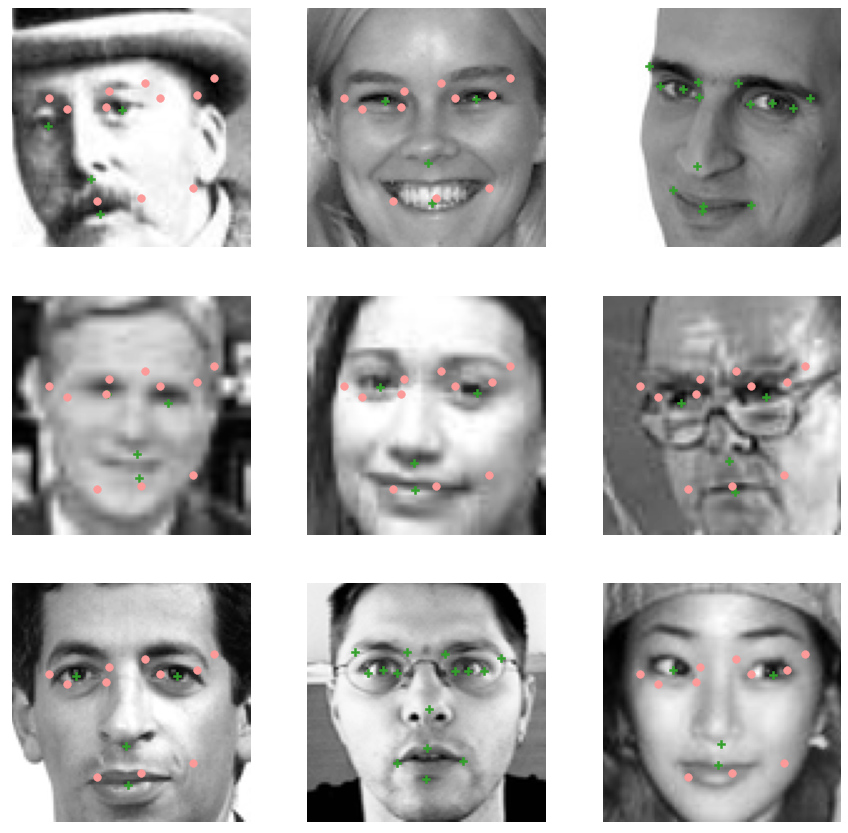

In [7]:
# the training output data requires handling missing data.

# approach 1, use values from the previous rows

# make a copy of the df so any modifications to the dataframe does not affect the original dataframe from the csv files
train_df1 = original_train_df.copy()

# use ffill() to fill in missing values, delete the image column to keep only the coordinates of point of interest
# convert into ndarray
train_df1.fillna(method="ffill", inplace = True)
del train_df1['Image']
train_output1 = train_df1.to_numpy()

# divide output data up into train and dev set
Y_train1 = train_output1[:6000]
Y_dev1 = train_output1[6000:]

print('training set output shape:', Y_train1.shape)
print('development set output shape:', Y_dev1.shape)

# generate 9 indicies to sample from the training data set, call the helper function to plot the pictures
idx = np.random.randint(0, X_train.shape[0], size = 9).tolist()
plot_images(X_train[np.array(idx)], Y_train_real[np.array(idx)], Y_train1[np.array(idx)])

training set output shape: (6000, 30)
development set output shape: (1049, 30)


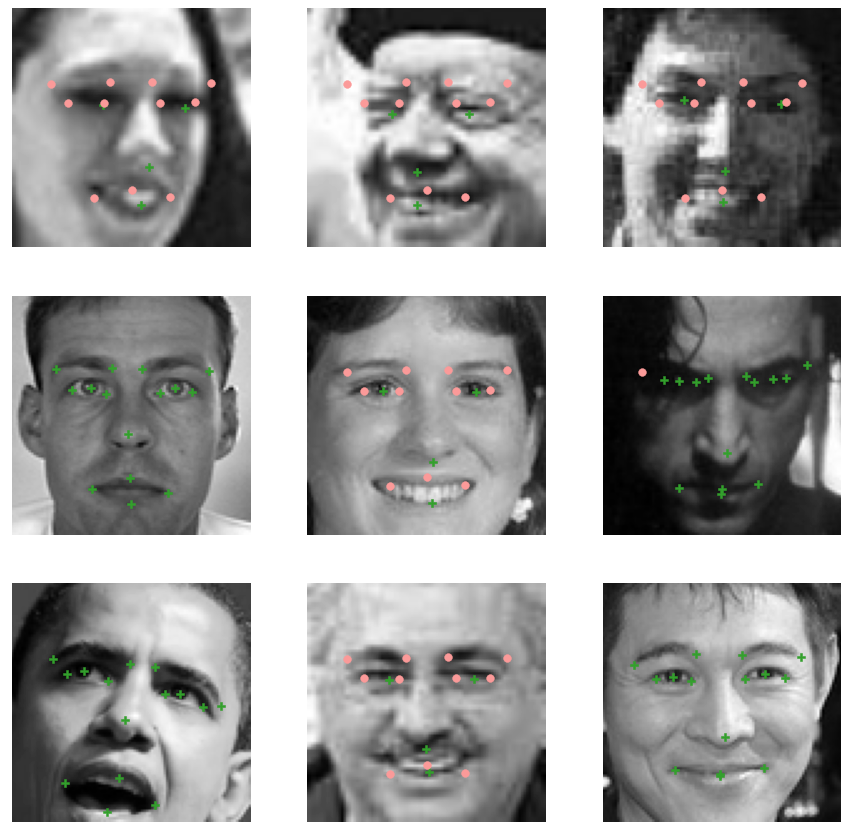

In [8]:
# approach 2, fillna with median of the column

train_df2 = original_train_df.copy()

# delete the image column to keep only the coordinates of point of interest, iterate through each column to fillna with median
# convert into ndarray
del train_df2['Image']
train_df2.fillna(train_df2.median(skipna = True), inplace=True)

train_output2 = train_df2.to_numpy() 
# divide output data up into train and dev set
Y_train2 = train_output2[:6000]
Y_dev2 = train_output2[6000:]

print('training set output shape:', Y_train2.shape)
print('development set output shape:', Y_dev2.shape)

# generate 9 indicies to sample from the training data set, call the helper function to plot the pictures
idx = np.random.randint(0, X_train.shape[0], size = 9).tolist()
plot_images(X_train[np.array(idx)], Y_train_real[np.array(idx)], Y_train2[np.array(idx)])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


Imputing row 1/7049 with 0 missing, elapsed time: 11.680
Imputing row 101/7049 with 0 missing, elapsed time: 11.680
Imputing row 201/7049 with 0 missing, elapsed time: 11.680
Imputing row 301/7049 with 0 missing, elapsed time: 11.681
Imputing row 401/7049 with 0 missing, elapsed time: 11.682
Imputing row 501/7049 with 0 missing, elapsed time: 11.683
Imputing row 601/7049 with 0 missing, elapsed time: 11.683
Imputing row 701/7049 with 0 missing, elapsed time: 11.683
Imputing row 801/7049 with 0 missing, elapsed time: 11.684
Imputing row 901/7049 with 0 missing, elapsed time: 11.684
Imputing row 1001/7049 with 0 missing, elapsed time: 11.685
Imputing row 1101/7049 with 0 missing, elapsed time: 11.685
Imputing row 1201/7049 with 0 missing, elapsed time: 11.686
Imputing row 1301/7049 with 0 missing, elapsed time: 11.686
Imputing row 1401/7049 with 0 missing, elapsed time: 11.686
Imputing row 1501/7049 with 0 missing, elapsed time: 11.687
Imputing row 1601/7049 with 0 missing, elapsed time:

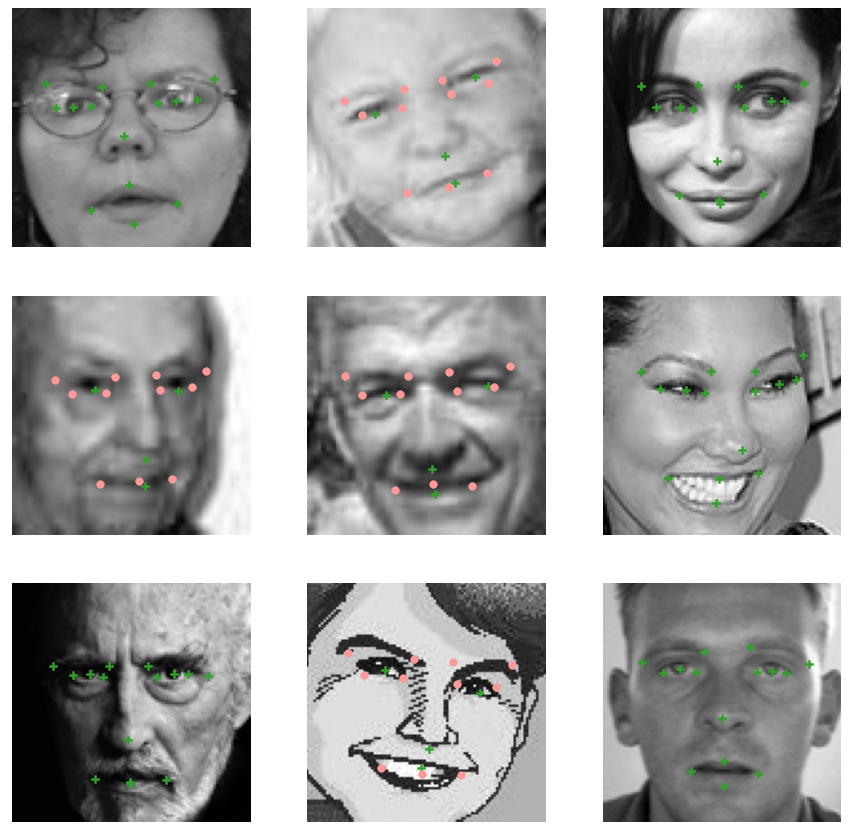

In [9]:
# approach 3, fillna using knn

train_df3 = original_train_df.copy()

from fancyimpute import KNN

# delete the image column, use fancy impute knn method to fill the missing output values
del train_df3['Image']

# fancy imput removes the column headers, so save the column headers temporarily to restore it later
column_names = train_df3.columns
train_df3 = pd.DataFrame(KNN(k=9).fit_transform(train_df3))
train_df3.columns = column_names

train_output3 = train_df3.to_numpy()
Y_train3 = train_output3[:6000]
Y_dev3 = train_output3[6000:]

print('training set output shape:', Y_train3.shape)
print('development set output shape:', Y_dev3.shape)

# generate 9 indicies to sample from the training data set, call the helper function to plot the pictures
idx = np.random.randint(0, X_train.shape[0], size = 9).tolist()
plot_images(X_train[np.array(idx)], Y_train_real[np.array(idx)], Y_train3[np.array(idx)])

# 3. Baseline Model using Naive LeNet-5

In [0]:
# Compile a basic LeNet-5 model

def create_naive_LeNet5_model(input_shape):
  # helper function that creates a LeNet5 CNN model, input is an integer indicating the shape of each training input
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
19/19 [==============================] - 1s 53ms/step - loss: 1178.2897 - mae: 25.4812 - val_loss: 206.4160 - val_mae: 11.4248
Epoch 2/50
19/19 [==============================] - 1s 32ms/step - loss: 182.3918 - mae: 10.3964 - val_loss: 136.0780 - val_mae: 8.8506
Epoch 3/50
19/19 [==============================] - 1s 33ms/step - loss: 134.6762 - mae: 8.8460 - val_loss: 115.8847 - val_mae: 7.9684
Epoch 4/50
19/19 [==============================] - 1s 32ms/step - loss: 112.1184 - mae: 7.9896 - val_loss: 96.4215 - val_mae: 7.2288
Epoch 5/50
19/19 [==============================] - 1s 32ms/step - loss: 96.6127 - mae: 7.3757 - val_loss: 90.3405 - val_mae: 6.9795
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 85.9344 - mae: 6.9313 - val_loss: 84.2935 - val_mae: 6.7539
Epoch 7/50
19/19 [==============================] - 1s 32ms/step - loss: 81.5490 - mae: 6.7419 - val_loss: 82.4507 - val_mae: 6.6687
Epo

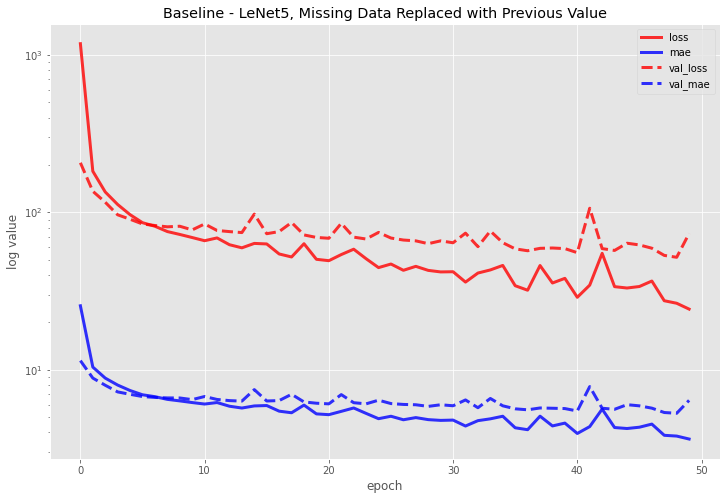

In [11]:
# baseline: LeNet5 + ffill for missing data

# call the helper function to create the model and then compile it
LeNet5_model1 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model1.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# train the model using the appropriate data
result_LeNet1 = LeNet5_model1.fit(X_train, Y_train1, epochs = 50, batch_size = 256, validation_split = 0.2)

# call the helper function to plot out the metrics at each epoch
plot_history(result_LeNet1.history, "Baseline - LeNet5, Missing Data Replaced with Previous Value")

33/33 [==============================] - 0s 4ms/step - loss: 80.8521 - mae: 6.6280


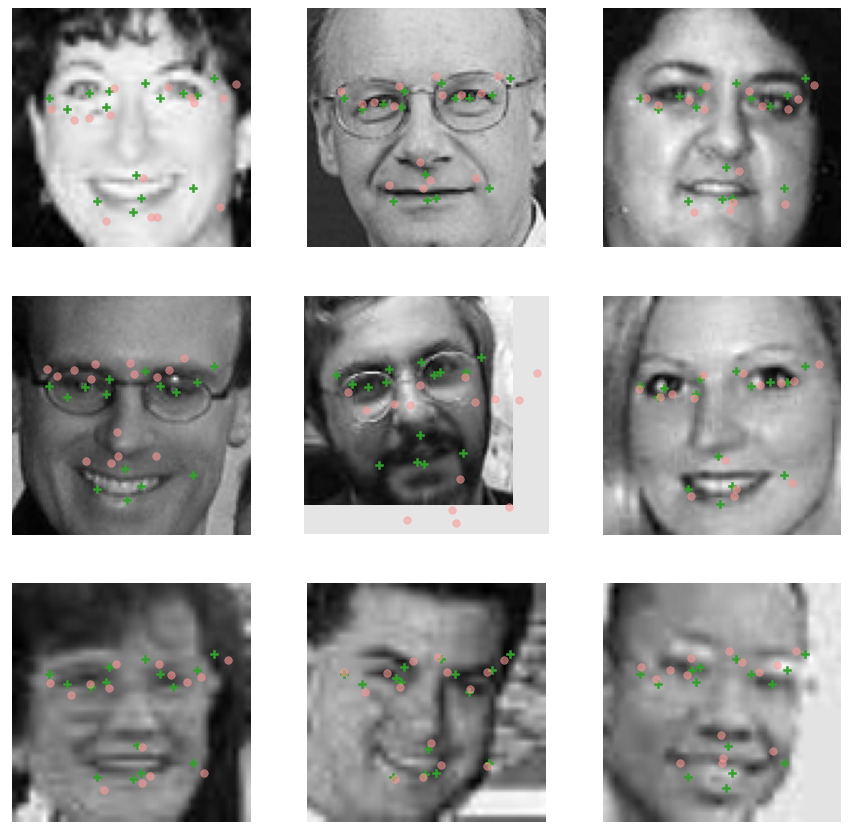

In [12]:
# baseline: LeNet5 + ffill for missing data

# evaluate the model using dev set
LeNet5_model1.evaluate(X_dev, Y_dev1)

# make predictions using dev set and visualize the predictions
Y_dev_predicted = LeNet5_model1.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev1[np.array(idx)], Y_dev_predicted[np.array(idx)], False)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
19/19 [==============================] - 1s 38ms/step - loss: 3148.7512 - mae: 40.4674 - val_loss: 745.6876 - val_mae: 21.7760
Epoch 2/50
19/19 [==============================] - 1s 32ms/step - loss: 421.3619 - mae: 16.3275 - val_loss: 202.3807 - val_mae: 11.2441
Epoch 3/50
19/19 [==============================] - 1s 32ms/step - loss: 169.2175 - mae: 9.9975 - val_loss: 130.9710 - val_mae: 8.5511
Epoch 4/50
19/19 [==============================] - 1s 32ms/step - loss: 148.5517 - mae: 9.2177 - val_loss: 127.8696 - val_mae: 8.4034
Epoch 5/50
19/19 [==============================] - 1s 32ms/step - loss: 141.8666 - mae: 8.9879 - val_loss: 118.4277 - val_mae: 8.0716
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 128.0408 - mae: 8.5404 - val_loss: 107.8300 - val_mae: 7.6637
Epoch 7/50
19/19 [==============================] - 1s 33ms/step - loss: 117.3246 - mae: 8.1505 - val_loss: 100.0693 - val_mae: 7.

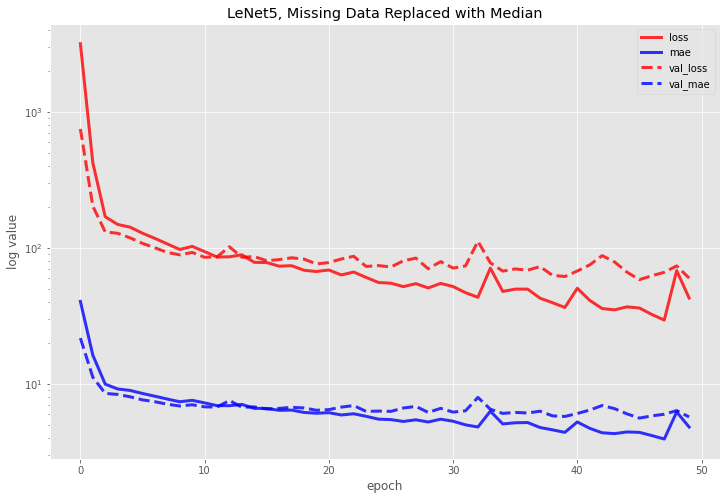

In [13]:
# LeNet5 + use median for missing data

# call the helper function to create the model and then compile it
LeNet5_model2 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# train the model using the appropriate data
result_LeNet2 = LeNet5_model2.fit(X_train, Y_train2, epochs = 50, batch_size = 256, validation_split = 0.2)

# call the helper function to plot out the metrics at each epoch
plot_history(result_LeNet2.history, "LeNet5, Missing Data Replaced with Median")

33/33 [==============================] - 0s 3ms/step - loss: 72.2905 - mae: 6.1837


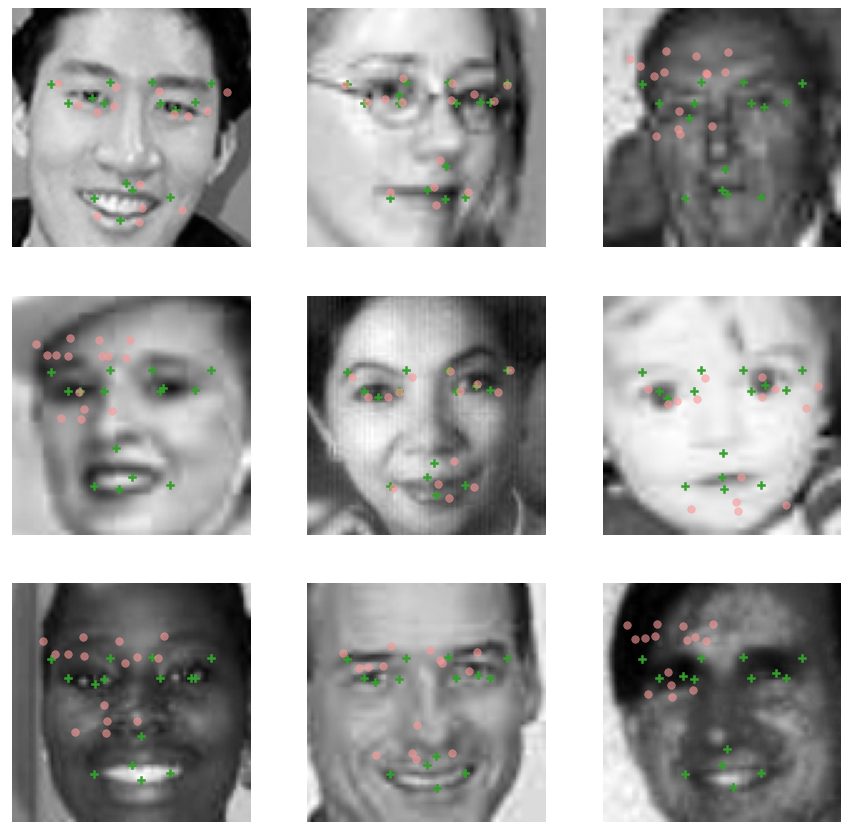

In [14]:
# LeNet5 + use median for missing data

# evaluate the model using dev set
LeNet5_model2.evaluate(X_dev, Y_dev2)

# make predictions using dev set and visualize the predictions
Y_dev_predicted = LeNet5_model2.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev2[np.array(idx)], Y_dev_predicted[np.array(idx)], False)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
19/19 [==============================] - 1s 40ms/step - loss: 1227.7806 - mae: 24.9945 - val_loss: 214.9023 - val_mae: 11.6145
Epoch 2/50
19/19 [==============================] - 1s 32ms/step - loss: 176.1232 - mae: 10.2842 - val_loss: 126.8391 - val_mae: 8.4501
Epoch 3/50
19/19 [==============================] - 1s 32ms/step - loss: 127.8339 - mae: 8.5978 - val_loss: 105.5059 - val_mae: 7.5802
Epoch 4/50
19/19 [==============================] - 1s 33ms/step - loss: 108.3535 - mae: 7.8764 - val_loss: 94.1240 - val_mae: 7.1796
Epoch 5/50
19/19 [==============================] - 1s 31ms/step - loss: 96.3262 - mae: 7.3989 - val_loss: 91.5475 - val_mae: 7.1481
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 86.8936 - mae: 7.0058 - val_loss: 88.4740 - val_mae: 7.0533
Epoch 7/50
19/19 [==============================] - 1s 33ms/step - loss: 83.0878 - mae: 6.8614 - val_loss: 82.3154 - val_mae: 6.7449
Epo

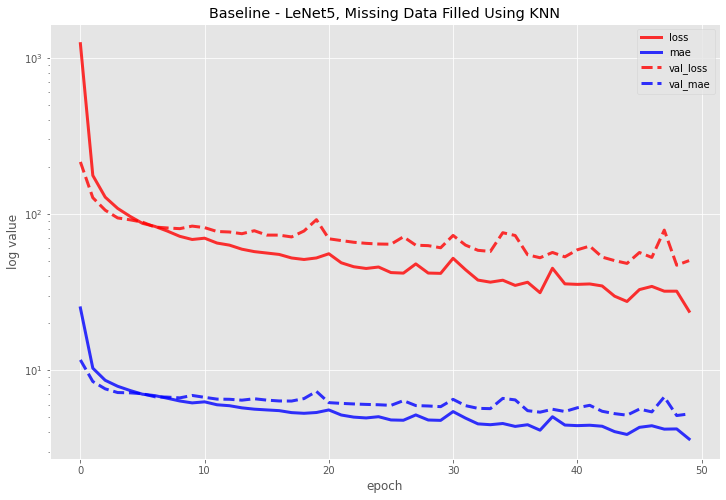

In [15]:
# LeNet5 + use knn to fill missing data

# call the helper function to create the model and then compile it
LeNet5_model3 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model3.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# train the model using the appropriate data
result_LeNet3 = LeNet5_model3.fit(X_train, Y_train3, epochs = 50, batch_size = 256, validation_split = 0.2)

# call the helper function to plot out the metrics at each epoch
plot_history(result_LeNet3.history, "Baseline - LeNet5, Missing Data Filled Using KNN")

33/33 [==============================] - 0s 3ms/step - loss: 57.7774 - mae: 5.4853


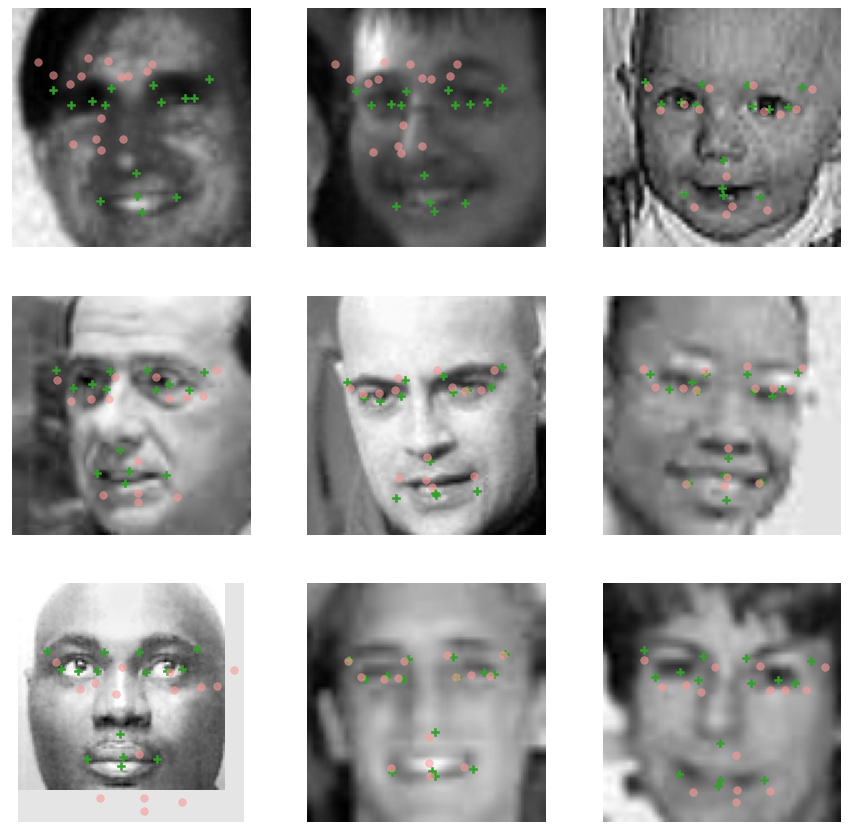

In [16]:
# LeNet5 + use knn to fill missing data

# evaluate the model using dev set
LeNet5_model3.evaluate(X_dev, Y_dev3)

# make predictions using dev set and visualize the predictions
Y_dev_predicted = LeNet5_model3.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev3[np.array(idx)], Y_dev_predicted[np.array(idx)], False)

# VGG16 and Image Augmentation

1. VGG16 model (single channel)

In [72]:
def create_vgg16_model_single_channel(input_shape):
  #need to have RGB
  
  #load VGG16 model pre-trained with imagenet
  single_channel_input = keras.layers.Input(shape=input_shape)
  single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])
  model_layer = keras.applications.VGG16(weights="imagenet", include_top=False)(single_channel_concat)
  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(model_layer)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = keras.layers.Dense  (30)(x) 
  model = keras.Model(single_channel_input, x) 
  return model

#test
VGG16_naive1 = create_vgg16_model_single_channel(X_train.shape[1:])
VGG16_naive1.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
VGG16_naive1.summary()

result_VGG1_naive = VGG16_naive1.fit(X_train, Y_train3, epochs = 50, batch_size = 256, validation_split = 0.2)

# call the helper function to plot out the metrics at each epoch
plot_history(result_VGG1_naive.history, "VGG16 with Transfer Learning, Missing Data Filled Using KNN")


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 96, 96, 3)    0           input_17[0][0]                   
                                                                 input_17[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
vgg16 (Model)                   multiple             14714688    concatenate_5[0][0]              
____________________________________________________________________________________________

KeyboardInterrupt: ignored

2. VGG16 with transfer learning

In [0]:
def create_vgg16_model_with_transfer_learning(input_shape):
  #need to have RGB
  
  #load VGG16 model pre-trained with imagenet
  pre_trained_model = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  
  #freeze convolutional layers
  for layer in pre_trained_model.layers:
    layer.trainable = False

  last_layer = pre_trained_model.get_layer('block5_pool')
  #last_layer = pre_trained_model
  last_output = last_layer.output
  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = keras.layers.Dense  (30)(x) 
  model = keras.Model( pre_trained_model.input, x) 
  return model

In [0]:
from skimage import transform
from skimage.transform import AffineTransform

class FacialPointImageDataGenerator(keras.utils.Sequence):
  '''FacialPointImageDataGenerator'''
  def __init__(self, X_data, y_data,horizontal_flip_prob=0, horizontall_flip_label=None,
               horizontal_shift_range=0.1, horizontal_shift_prob=0,
               shift_range = 0, 
               affine_transformation_prob = 0,
               to_fit=True, batch_size=32, image_size=(96,96), n_channels=1,
               shuffle=True, convertToRGB=False):
    self.to_fit = to_fit
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.horizontal_flip_prob = horizontal_flip_prob
    self.horizontal_center = image_size[0]//2;
    # need to update the labels if we flip the image horizontally
    # for example left_eye_center_x becomes right_eye_center_x
    self.horizontal_flip_label = {"orig" : [0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 22, 23],
                  "new"  : [2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25]} if  horizontall_flip_label is None else horizontall_flip_label

    self.horizontal_flip_fn = np.vectorize(self.horizontal_flip)
    self.shift_range = shift_range
    self.w_shift_max = int(image_size[0] * shift_range)
    self.h_shift_max = int(image_size[1] * shift_range)
    self.affine_transformation_prob = affine_transformation_prob
    
    self.X_data = X_data
    self.y_data = y_data
    self.convertToRGB = convertToRGB #need it to use pre-trained VGG16 which expects RGB(3-channel) data
    self.on_epoch_end()

  #helpfer function for performing horizontal flip
  @staticmethod
  def horizontal_flip(element ,center):
    if element < center:
      element = center + (center - element)
    else:
      element = center - (element - center)
    return element
  
  #helpfer function for performing affine transformation
  def transform_image(self, X_data, y_data):
      translation = (np.random.uniform(-1*self.w_shift_max, self.w_shift_max),
                    np.random.uniform(-1*self.h_shift_max, self.h_shift_max))
      
      transformation_matrix = AffineTransform(
            translation=translation
      )

      X_transformed = transform.warp(X_data, transformation_matrix, mode="edge")
      y_data[::2] += -translation[0]
      y_data[1::2] += -translation[1]
      return (X_transformed, y_data)

  def __len__(self):
    '''Number of batches per epoch'''
    return math.ceil(self.X_data.shape[0] / self.batch_size)
  
  def on_epoch_end(self):
    '''Called at the end of every epoch. Shuffle indices?'''
    self.indexes = np.arange(self.X_data.shape[0])
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self, index):
    '''Generate one batch of data'''
    #generate indexes
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    current_batch_size = len(indexes)
    #get the data
    X_batch = self.X_data[indexes]
    y_batch = self.y_data[indexes]

    #handle horizontal flip
    if self.horizontal_flip_prob > 0:
      horizontal_flip_index = np.random.choice(current_batch_size, int(self.horizontal_flip_prob * current_batch_size), replace=False)
      X_batch[horizontal_flip_index] = X_batch[horizontal_flip_index, :, ::-1,:]
      for index in horizontal_flip_index:
        target_y = y_batch[index]
        target_y_rotated = self.horizontal_flip_fn(target_y, self.horizontal_center)
        target_y_rotated[1::2] = target_y[1::2]
        ## need to flip indicies
        y_batch_orig = target_y_rotated[self.horizontal_flip_label["orig"]]
        target_y_rotated[self.horizontal_flip_label["orig"]] = target_y_rotated[self.horizontal_flip_label["new"]]
        target_y_rotated[self.horizontal_flip_label["new"]]  = y_batch_orig   
        y_batch[index] = target_y_rotated

    #handle affine transformation
    if self.affine_transformation_prob > 0:
      for index in range(current_batch_size):
        X_batch[index], y_batch[index] = self.transform_image(X_batch[index],y_batch[index])
    
    if self.convertToRGB:
      X_batch = np.repeat(X_batch,3,axis=-1)
    return X_batch, y_batch

In [20]:
VGG16_transfer1 = create_vgg16_model_with_transfer_learning((96,96,3))
VGG16_transfer1.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
VGG16_transfer1.summary()

train_datagen_no_augment = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= Y_train3,
    affine_transformation_prob=0,
    horizontal_flip_prob=0,
    convertToRGB=True)

result_VGG1 = VGG16_transfer1.fit_generator(generator=train_datagen_no_augment,epochs=50)

# call the helper function to plot out the metrics at each epoch
plot_history(result_VGG1.history, "VGG16 with Transfer Learning, Missing Data Filled Using KNN")

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

KeyboardInterrupt: ignored

In [28]:
dev_datagen_no_augment = FacialPointImageDataGenerator(
    X_data= X_dev,
    y_data= Y_dev3,
    affine_transformation_prob=0,
    horizontal_flip_prob=0,
    convertToRGB=True)

print(VGG16_transfer1.evaluate_generator(generator=dev_datagen_no_augment))

# make predictions using dev set and visualize the predictions
Y_dev_predicted = VGG16_transfer1.predict_generator(generator=dev_datagen_no_augment)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev3[np.array(idx)], Y_dev_predicted[np.array(idx)], False)

KeyboardInterrupt: ignored

187/187 [==============================] - 8s 45ms/step - loss: 150.7110 - mae: 6.7724


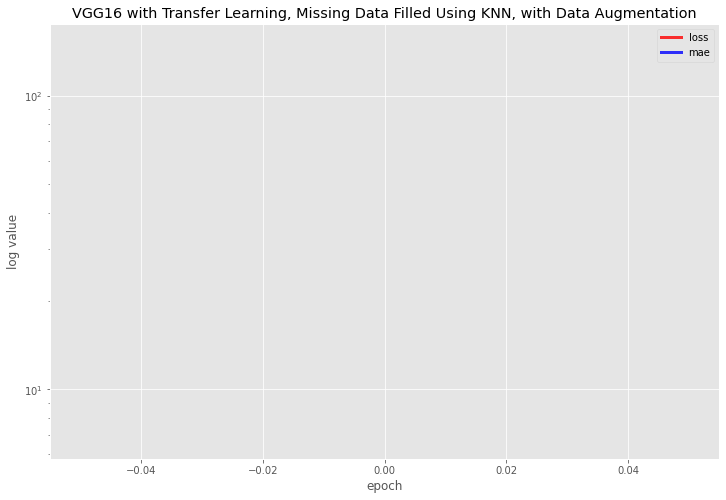

In [31]:
VGG16_transfer2 = create_vgg16_model_with_transfer_learning((96,96,3))
VGG16_transfer2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

train_datagen_augmented = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= Y_train3,
    affine_transformation_prob=0.5,
    horizontal_flip_prob=0.5,
    convertToRGB=True)

result_VGG2 = VGG16_transfer2.fit_generator(generator=train_datagen_augmented,epochs=1)

# call the helper function to plot out the metrics at each epoch
plot_history(result_VGG2.history, "VGG16 with Transfer Learning, Missing Data Filled Using KNN, with Data Augmentation")

[9.73897647857666, 2.057912826538086]


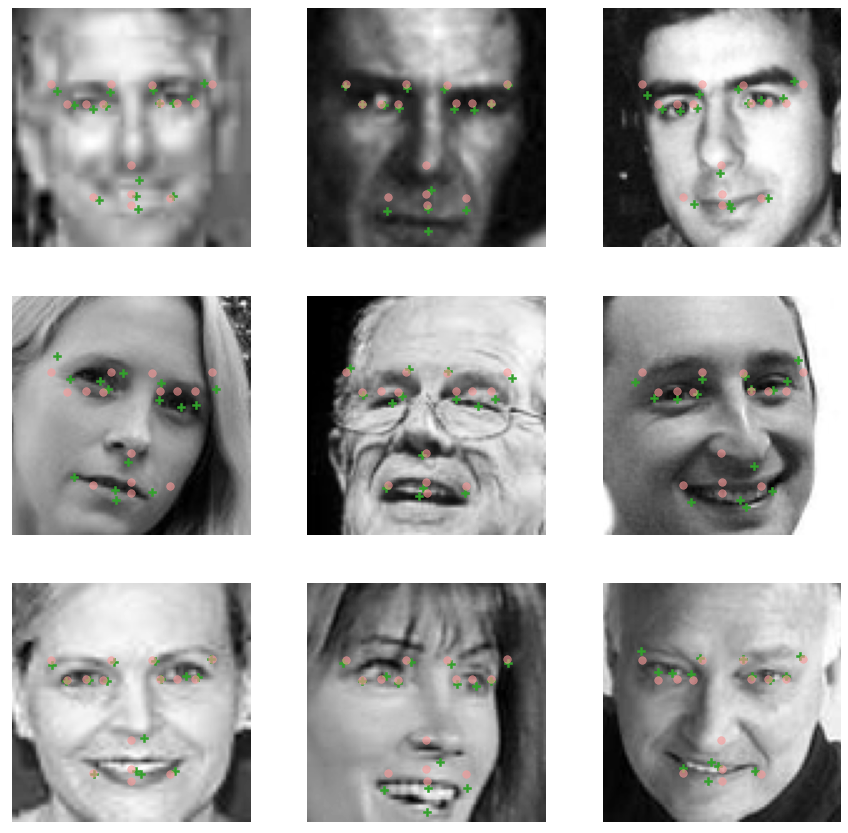

In [60]:
dev_datagen_augmented = FacialPointImageDataGenerator(
    X_data= X_dev,
    y_data= Y_dev3,
    affine_transformation_prob=0.5,
    horizontal_flip_prob=0.5,
    convertToRGB=True)

print(VGG16_transfer2.evaluate_generator(generator=dev_datagen_augmented))

# make predictions using dev set and visualize the predictions
Y_dev_predicted = VGG16_transfer2.predict_generator(generator=dev_datagen_augmented)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev3[np.array(idx)], Y_dev_predicted[np.array(idx)], False)

In [61]:
print(X_dev.shape)
print(Y_dev3.shape)
print(Y_dev_predicted.shape)

(1049, 96, 96, 1)
(1049, 30)
(1049, 30)
